In [1]:
import torch
import torch.nn as nn
import torch.fx as fx
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [2]:
DATA_ROOT = "../data"
tx = transforms.Compose([transforms.ToTensor(), 
                         transforms.Normalize([0.2860], [0.3530])
                         ])

print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

True
cuda


In [3]:
train_ds = datasets.FashionMNIST(
    root=DATA_ROOT,
    train=True,
    transform=tx,
    download=True
)
print(len(train_ds))

test_ds = datasets.FashionMNIST(
    root=DATA_ROOT,
    train=False,
    transform=tx,
    download=True
)
print(len(test_ds))

60000
10000


In [4]:
train_loader = DataLoader(
    train_ds,
    batch_size=64,
    shuffle=True,
    num_workers=0
)

test_loader = DataLoader(
    test_ds,
    batch_size=64,
    shuffle=False,
    num_workers=0
)

In [5]:
images, labels = next(iter(train_loader))
print(images.shape, labels.shape)


torch.Size([64, 1, 28, 28]) torch.Size([64])


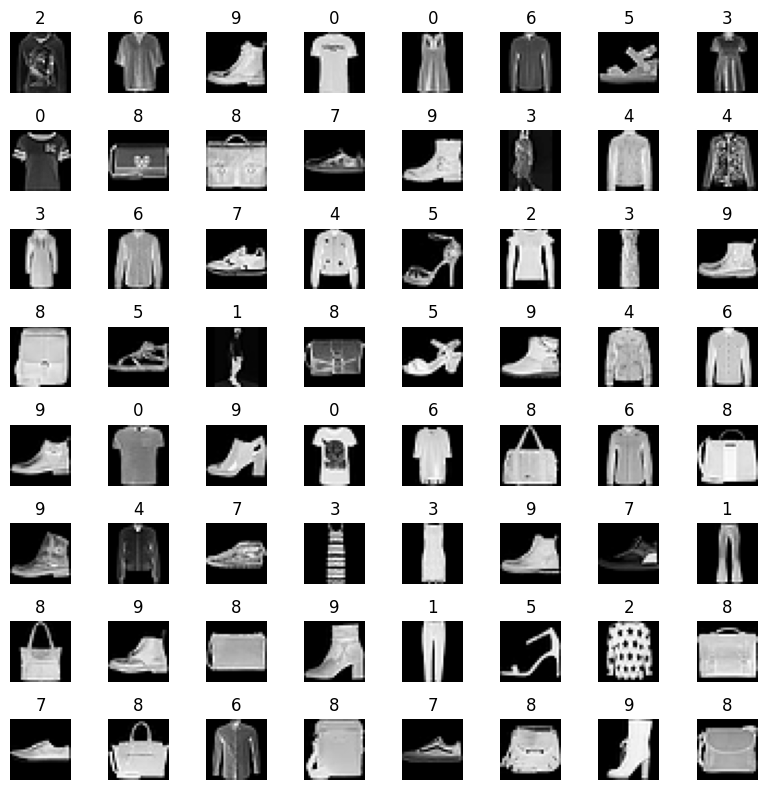

In [6]:
plt.figure(figsize=(8, 8))
for i in range(64):
    plt.subplot(8, 8, i+1)
    plt.axis("off")
    plt.imshow(images[i].squeeze(0), cmap="gray")
    plt.title(int(labels[i]))

plt.tight_layout()
plt.show()

In [9]:
class FashionCNN_BSL(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(784, 10)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.net(x)

net = FashionCNN_BSL()
print(net)
test_result = net.forward(images)
print(test_result.shape)

FashionCNN_BSL(
  (net): Sequential(
    (0): Linear(in_features=784, out_features=10, bias=True)
  )
)
torch.Size([64, 10])


In [10]:
num_epochs = 30
model = FashionCNN_BSL().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [11]:
@torch.no_grad()
def evaluate(model, criterion, loader, device=device):
    model.eval()
    total_correct = 0
    total_samples = 0
    running_loss = 0.0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)
        running_loss += float(loss.item())
        pred = logits.argmax(dim=1)
        total_correct += int((pred == y).sum().item())
        total_samples += int(y.size(0))
    
    avg_loss = running_loss / len(loader)
    acc = total_correct / max(1, total_samples)
    return {"loss": avg_loss, "acc": acc}

In [12]:
best_acc = -1.0
train_losses, val_losses, val_accs = [], [], []

for epoch in range(1, num_epochs + 1):
    model.train()
    running = 0.0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running += float(loss.item())
    train_loss = running / len(train_loader)

    metrics = evaluate(model, criterion, test_loader)
    val_loss = metrics["loss"]
    val_acc = metrics["acc"]

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Epoch {epoch:02d}/{num_epochs} | "
              f"train={train_loss:.4f}  val={val_loss:.4f}  acc={val_acc*100:5.2f}%")


Epoch 01/30 | train=0.9839  val=0.7417  acc=75.01%
Epoch 02/30 | train=0.6732  val=0.6480  acc=77.73%
Epoch 03/30 | train=0.6081  val=0.6055  acc=79.36%
Epoch 04/30 | train=0.5732  val=0.5794  acc=80.14%
Epoch 05/30 | train=0.5506  val=0.5620  acc=80.68%
Epoch 06/30 | train=0.5341  val=0.5498  acc=81.12%
Epoch 07/30 | train=0.5216  val=0.5391  acc=81.41%
Epoch 08/30 | train=0.5117  val=0.5320  acc=81.64%
Epoch 09/30 | train=0.5034  val=0.5249  acc=81.85%
Epoch 10/30 | train=0.4962  val=0.5190  acc=82.08%
Epoch 11/30 | train=0.4904  val=0.5142  acc=82.25%
Epoch 12/30 | train=0.4852  val=0.5097  acc=82.39%
Epoch 13/30 | train=0.4805  val=0.5058  acc=82.52%
Epoch 14/30 | train=0.4762  val=0.5025  acc=82.72%
Epoch 15/30 | train=0.4728  val=0.4990  acc=82.77%
Epoch 16/30 | train=0.4692  val=0.4968  acc=82.70%
Epoch 17/30 | train=0.4661  val=0.4941  acc=82.88%
Epoch 18/30 | train=0.4633  val=0.4915  acc=82.94%
Epoch 19/30 | train=0.4606  val=0.4896  acc=82.88%
Epoch 20/30 | train=0.4582  val

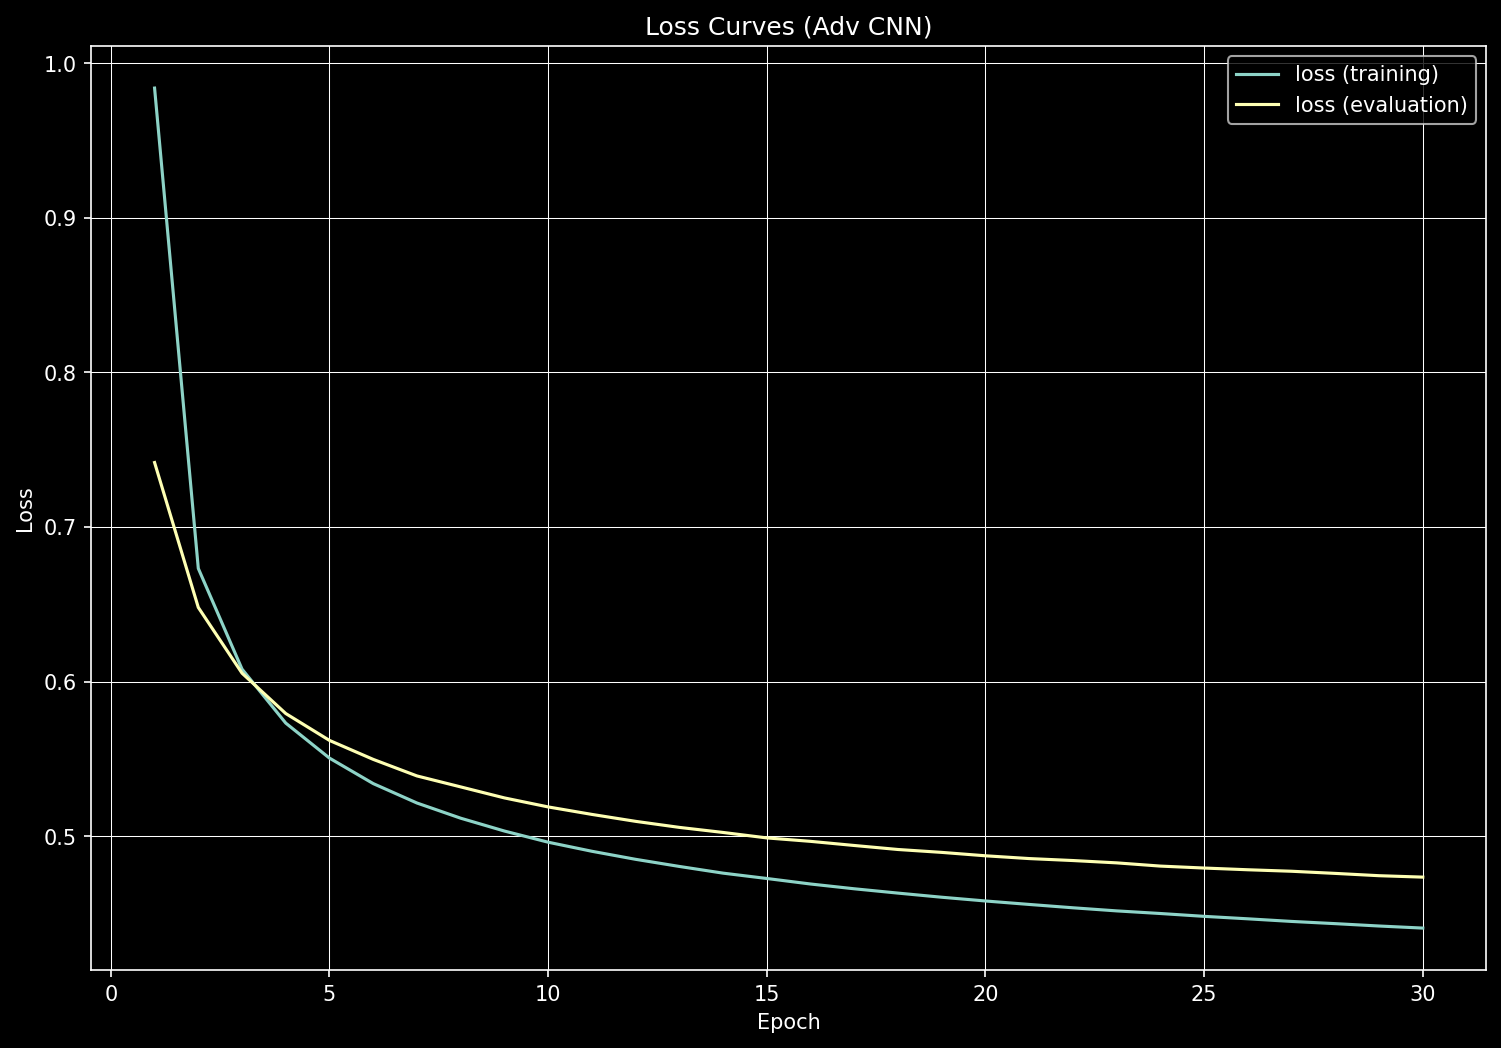

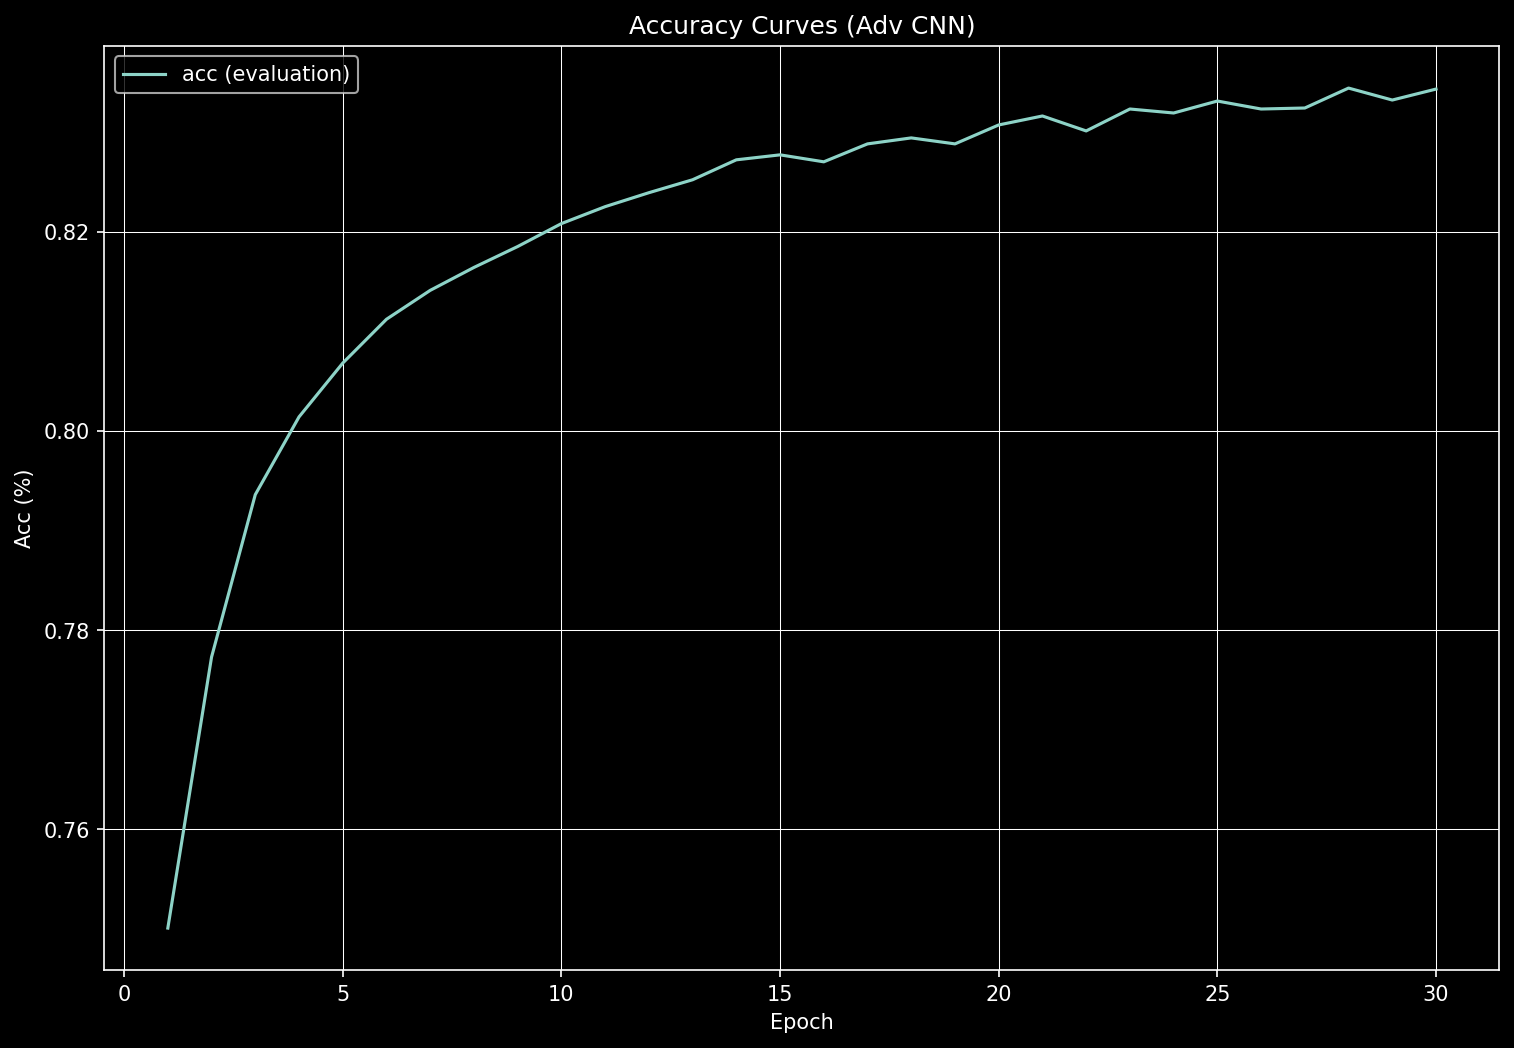

In [14]:
plt.style.use("dark_background")

epoch_x = np.arange(1, 31)
plt.figure(figsize=(12, 8), dpi=150)
plt.plot(epoch_x, train_losses, label='loss (training)')
plt.plot(epoch_x, val_losses, label='loss (evaluation)')
plt.grid(True, linewidth=0.5)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curves (Adv CNN)")
plt.savefig("../results/loss_curve_baseline.png")
plt.show()

plt.figure(figsize=(12, 8), dpi=150)
plt.plot(epoch_x, val_accs, label='acc (evaluation)')
plt.grid(True, linewidth=0.5)
plt.xlabel("Epoch")
plt.ylabel("Acc (%)")
plt.legend()
plt.title("Accuracy Curves (Adv CNN)")
plt.savefig("../results/accuracy_curve_baseline.png")
plt.show()

In [31]:
@torch.no_grad()
def collect_misclassified(model, loader, device=device):
    model.eval()
    wrong_images, wrong_preds, wrong_labels = [], [], []

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        pred = logits.argmax(dim=1)

        mask = (pred != y)
        if mask.any():
            x_wrong = x[mask].detach().cpu()
            pred_wrong = pred[mask].detach().cpu()
            y_wrong = y[mask].detach().cpu()

            wrong_images.append(x_wrong)
            wrong_preds.append(pred_wrong)
            wrong_labels.append(y_wrong)

    if len(wrong_images) == 0:
        return None, None, None
    
    wrong_images = torch.cat(wrong_images, dim=0)
    wrong_preds  = torch.cat(wrong_preds, dim=0)
    wrong_labels = torch.cat(wrong_labels, dim=0)
    return wrong_images, wrong_preds, wrong_labels

def denormalize(img_tensor, mean=0.2860, std=0.3530):
    return img_tensor * std + mean

CLASSES = ["T-shirt/top","Trouser","Pullover","Dress","Coat",
           "Sandal","Shirt","Sneaker","Bag","Ankle boot"]

def pick_first_n(images, preds, labels, N=25):
    N = min(N, images.size(0))
    return images[:N], preds[:N], labels[:N]

def plot_misclassified_grid(images, preds, labels, save_path, nrow=5):

    N = images.size(0)
    ncol = nrow
    nrow = int(np.ceil(N / ncol))

    plt.figure(figsize=(ncol*2.4, nrow*2.4), dpi=150)
    for i in range(N):
        plt.subplot(nrow, ncol, i+1)
        img = denormalize(images[i]).squeeze(0).numpy()
        plt.imshow(img, cmap="gray")
        true_name = CLASSES[int(labels[i])]
        pred_name = CLASSES[int(preds[i])]
        plt.title(f"T:{true_name}\nP:{pred_name}", fontsize=8)
        plt.axis("off")

    plt.tight_layout(pad=0.6)
    plt.savefig(save_path, bbox_inches="tight")
    plt.show()

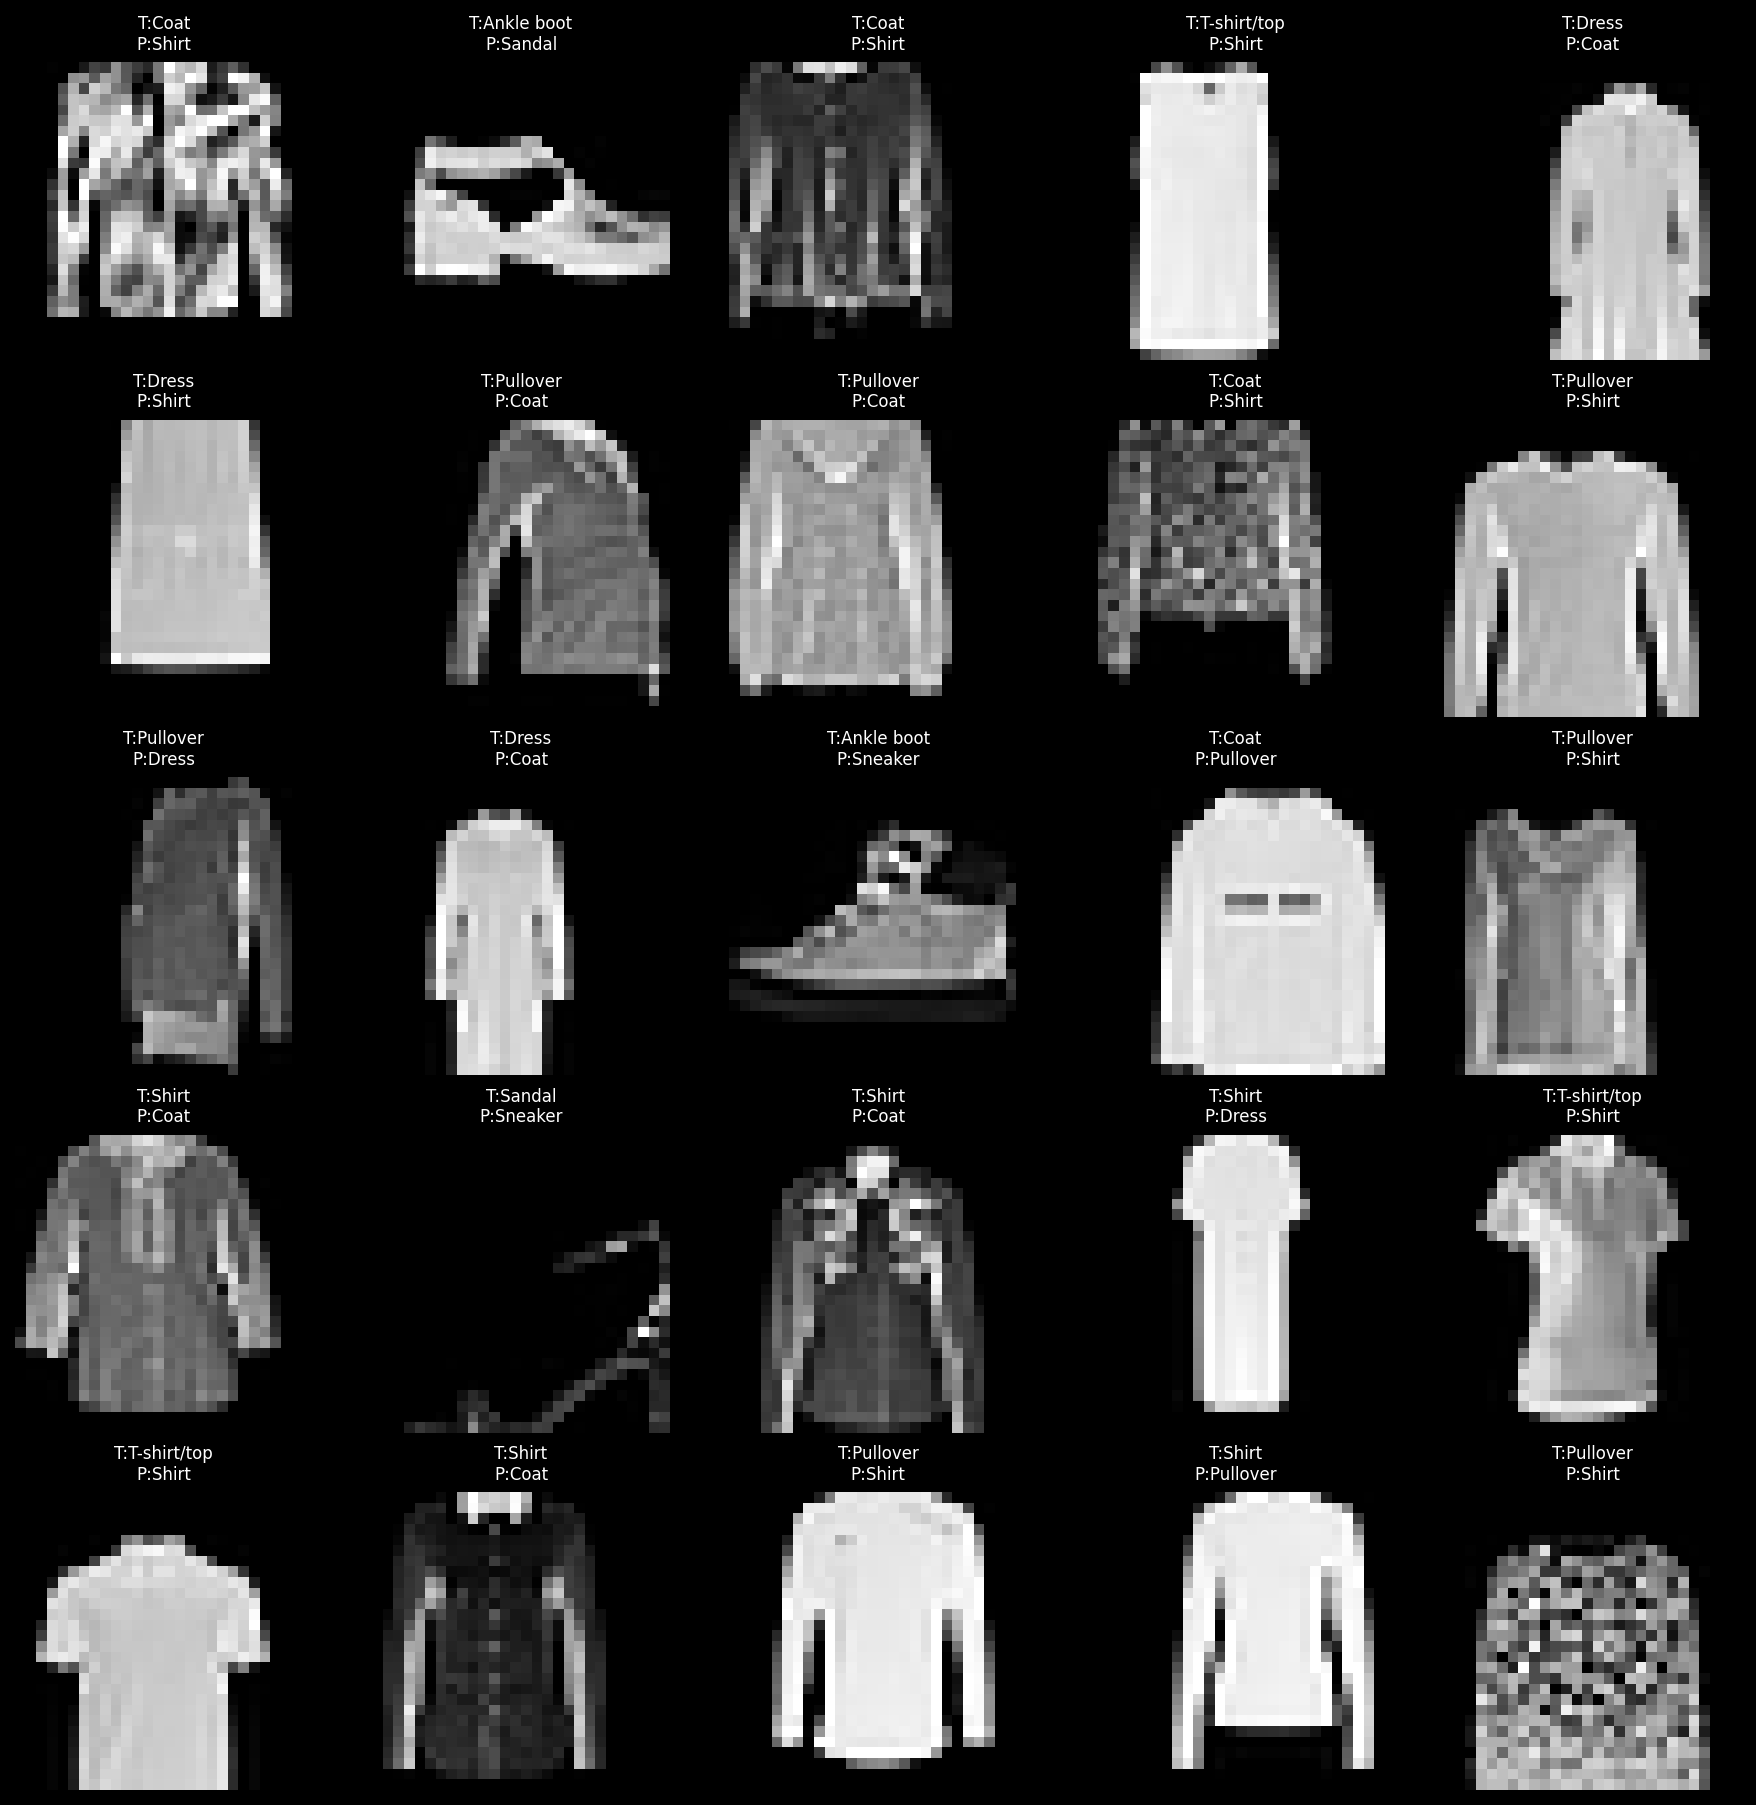

In [32]:
wrong_imgs, wrong_preds, wrong_labels = collect_misclassified(model, test_loader, device)

sel_imgs, sel_preds, sel_labels = pick_first_n(wrong_imgs, wrong_preds, wrong_labels, N=25)
plot_misclassified_grid(
    sel_imgs, sel_preds, sel_labels,
    save_path="../results/misclassified/misclassified_samples.png",
    nrow=5
)